## Import Packages

In [33]:
import tensorflow as tf
import pandas as pd
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


## Read File

In [34]:
data = pd.read_csv('OnlineNewsPopularity.csv')
data.columns = [col.strip() for col in data.columns]


## Create isolation forest model to remove outliers
[API Link to IF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)

In [35]:
old_data_length = len(data)
IF_model = IsolationForest(contamination=0.1) # Remove 10% data
outliers = IF_model.fit_predict(data.drop(columns=['url', 'timedelta', 'shares'])) # Delete columns than don't need in IF and train IF model
data['outliers'] = outliers

# Remove outliers
data_outliers = data[data['outliers'] == -1]
new_data = data[data['outliers'] != -1].drop(columns = ['outliers'])

new_data_len = len(new_data)

print(f"There are total {old_data_length - new_data_len} rows been removied.")


/Users/will./anaconda3/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


There are total 3965 rows been removied.


## Creat a function to classify an article to different categories
* Great Article: Shares >= 90%
* Good Article: 70% <= Shares < 90%
* Normal Article: 30% <= Shares < 70%
* Bad article: Shares < 30%

In [36]:
def article_classifier(shares, top_percent):
    if shares >= top_percent[0.9]:
        return 'Great'
    elif shares >= top_percent[0.7]:
        return 'Good'
    elif shares >= top_percent[0.3]:
        return 'Normal'
    else:
        return 'Bad'
        

## Data Classifier

In [37]:
top_percent = new_data['shares'].quantile([0.3, 0.7, 0.9])

quality = []
for index, row in new_data.iterrows():
    quality.append(article_classifier(row['shares'], top_percent))

new_data['quality'] = quality


## Split dataset into x and y and one-hot encode quality column

In [38]:
x = new_data.drop(columns=['quality', 'url', 'timedelta', 'shares'], axis=1)
y = OneHotEncoder().fit_transform(new_data[['quality']]).toarray()


## Train test split

In [39]:

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=10)


## Scale the data to Improve the speed of training Model

In [40]:
!pip install matplotlib

<span style="color:red">Since the data is not normally distributed, so we may not use the standardization. Plus, the range doesn't vary from 0 to 1.</span>

range of the xTrain:
n_tokens_title                   2.000000e+01
n_tokens_content                 7.057000e+03
n_unique_tokens                  8.127916e-01
n_non_stop_words                 7.117500e-08
n_non_stop_unique_tokens         7.880987e-01
num_hrefs                        3.040000e+02
num_self_hrefs                   7.400000e+01
num_imgs                         1.000000e+02
num_videos                       6.500000e+01
average_token_length             4.416949e+00
num_keywords                     9.000000e+00
data_channel_is_lifestyle        1.000000e+00
data_channel_is_entertainment    1.000000e+00
data_channel_is_bus              1.000000e+00
data_channel_is_socmed           1.000000e+00
data_channel_is_tech             1.000000e+00
data_channel_is_world            1.000000e+00
kw_min_min                       3.190000e+02
kw_max_min                       5.000000e+04
kw_avg_min                       8.495333e+03
kw_min_max                       8.433000e+05
kw_max_max   

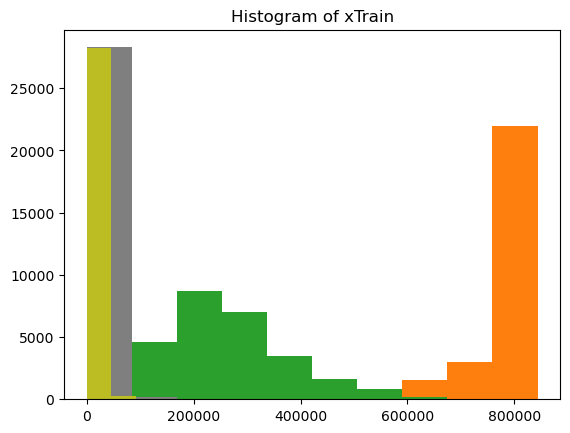

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import pandas as pd

scaler = MinMaxScaler()
scale_xTrain = scaler.fit_transform(xTrain)
scale_xTest = scaler.fit_transform(xTest)

print("range of the xTrain:")
print(xTrain.max() - xTrain.min())
for i in xTrain.columns:
    plt.hist(xTrain[i])
plt.title("Histogram of xTrain")
plt.show()



## Create and train model(NN)

In [42]:
def build_nn_model(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

mirror_strategy = tf.distribute.MirroredStrategy()
with mirror_strategy.scope():
    nn_model1 = build_nn_model(scale_xTrain.shape[1:], yTrain.shape[1])
    nn_model2 = build_nn_model(scale_xTrain.shape[1:], yTrain.shape[1])

    fit_speed = tf.data.Dataset.from_tensor_slices((scale_xTrain, yTrain))
    fit_speed = fit_speed.repeat().batch(100)

    nn_model1.fit(scale_xTrain, yTrain, epochs=10)
    nn_model2.fit(scale_xTrain, yTrain, epochs=10)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Epoch 1/10
 96/892 [==>...........................] - ETA: 0s - loss: 1.2624 - accuracy: 0.4134  

2023-08-31 21:21:03.240464: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


892/892 [==============================] - 1s 544us/step - loss: 1.2211 - accuracy: 0.4328
Epoch 2/10
892/892 [==============================] - 0s 555us/step - loss: 1.2041 - accuracy: 0.4433
Epoch 3/10
892/892 [==============================] - 1s 576us/step - loss: 1.1965 - accuracy: 0.4445
Epoch 4/10
892/892 [==============================] - 1s 568us/step - loss: 1.1893 - accuracy: 0.4488
Epoch 5/10
892/892 [==============================] - 0s 547us/step - loss: 1.1850 - accuracy: 0.4522
Epoch 6/10
892/892 [==============================] - 0s 552us/step - loss: 1.1804 - accuracy: 0.4537
Epoch 7/10
892/892 [==============================] - 1s 566us/step - loss: 1.1758 - accuracy: 0.4570
Epoch 8/10
892/892 [==============================] - 0s 552us/step - loss: 1.1710 - accuracy: 0.4585
Epoch 9/10
892/892 [==============================] - 0s 544us/step - loss: 1.1682 - accuracy: 0.4618
Epoch 10/10
892/892 [==============================] - 0s 547us/step - loss: 1.1653 - accurac

## Create and train model(Random Forest)

In [43]:
RF_model = RandomForestClassifier(n_estimators=100)
RF_model.fit(scale_xTrain, yTrain.argmax(axis=1))


RandomForestClassifier()

## Make predictions with each model individually

In [44]:
nn1_train_pred = nn_model1.predict(scale_xTrain)
nn2_train_pred = nn_model2.predict(scale_xTrain)
RF_train_pred = RF_model.predict_proba(scale_xTrain)

nn1_test_pred = nn_model1.predict(scale_xTest)
nn2_test_pred = nn_model2.predict(scale_xTest)
RF_test_pred = RF_model.predict_proba(scale_xTest)

print("Shape:")
print("nn1_train_pred:", nn1_train_pred.shape)
print("nn2_train_pred:", nn2_train_pred.shape)
print("RF_train_pred:", RF_train_pred.shape)

nn1_train_labels = nn1_train_pred.argmax(axis=1)
nn2_train_labels = nn2_train_pred.argmax(axis=1)
RF_train_labels = RF_train_pred.argmax(axis=1)

nn1_test_labels = nn1_test_pred.argmax(axis=1)
nn2_test_labels = nn2_test_pred.argmax(axis=1)
RF_test_labels = RF_test_pred.argmax(axis=1)

print("Labels:")
print("nn1_train_pred:", nn1_train_labels)
print("nn2_train_pred:", nn2_train_labels)
print("RF_train_pred:", RF_train_labels)
print("nn1_test_pred:", nn1_test_labels)
print("nn2_test_pred:", nn2_test_labels)
print("RF_test_pred:", RF_test_labels)
print()

223/223 [==============================] - 0s 332us/step
Shape:
nn1_train_pred: (28543, 4)
nn2_train_pred: (28543, 4)
RF_train_pred: (28543, 4)
Labels:
nn1_train_pred: [3 0 0 ... 3 3 3]
nn2_train_pred: [3 3 0 ... 3 3 3]
RF_train_pred: [3 1 0 ... 3 3 2]
nn1_test_pred: [3 3 3 ... 3 0 3]
nn2_test_pred: [3 3 3 ... 3 0 3]
RF_test_pred: [3 1 0 ... 1 3 3]



## Simple Ensemble: 3 linear models

## Train the 3 linear models

In [45]:
from sklearn.linear_model import LinearRegression
linmodel_1 = LinearRegression()
linmodel_2 = LinearRegression()
linmodel_3 = LinearRegression()

linmodel_1.fit(scale_xTrain,yTrain)
linmodel_2.fit(scale_xTrain,yTrain)
linmodel_3.fit(scale_xTrain,yTrain)

LinearRegression()

## Get the predictions out of the 3 linear regression models

In [46]:
linmodel1_train_pred = linmodel_1.predict(scale_xTrain)
linmodel2_train_pred = linmodel_2.predict(scale_xTrain)
linmodel3_train_pred = linmodel_3.predict(scale_xTrain)

linmodel1_test_pred = linmodel_1.predict(scale_xTest)
linmodel2_test_pred = linmodel_2.predict(scale_xTest)
linmodel3_test_pred = linmodel_3.predict(scale_xTest)

## Get the ensemble prediction

In [47]:
ensemble_simple_train_pred = (linmodel1_train_pred + linmodel2_train_pred + linmodel3_train_pred) / 3
ensemble_simple_test_pred = (linmodel1_test_pred + linmodel2_test_pred + linmodel3_test_pred) / 3

ensemble_simple_train_labels = ensemble_simple_train_pred.argmax(axis=1)
ensemble_simple_test_labels = ensemble_simple_test_pred.argmax(axis=1)

## (Simple Ensemble) Classification Report 

In [48]:
print("Train:")
print(classification_report(yTrain.argmax(axis=1), ensemble_simple_train_labels))
print("Test:")
print(classification_report(yTest.argmax(axis=1), ensemble_simple_test_labels))

print("Training error")

Train:
              precision    recall  f1-score   support

           0       0.48      0.50      0.49      8336
           1       0.38      0.04      0.07      5650
           2       0.38      0.03      0.06      2918
           3       0.44      0.72      0.55     11639

    accuracy                           0.45     28543
   macro avg       0.42      0.32      0.29     28543
weighted avg       0.43      0.45      0.39     28543

Test:
              precision    recall  f1-score   support

           0       0.28      0.83      0.41      2101
           1       0.00      0.00      0.00      1425
           2       0.00      0.00      0.00       712
           3       0.39      0.12      0.18      2898

    accuracy                           0.29      7136
   macro avg       0.17      0.24      0.15      7136
weighted avg       0.24      0.29      0.20      7136

Training error


/Users/will./anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/will./anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/will./anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Complex Ensemble: 2 NN + 1 RF

In [49]:
ensemble_train_pred = (nn1_train_pred + nn2_train_pred + RF_train_pred) / 3
ensemble_test_pred = (nn1_test_pred + nn2_test_pred + RF_test_pred) / 3

ensemble_train_labels = ensemble_train_pred.argmax(axis=1)
ensemble_test_labels = ensemble_test_pred.argmax(axis=1)

print("ensemble_train_labels:",ensemble_train_labels)
print("ensemble_train_labels:",ensemble_train_labels)


ensemble_train_labels: [3 1 0 ... 3 3 3]
ensemble_train_labels: [3 1 0 ... 3 3 3]


## Model Evaluation

In [50]:
print("Train:")
print(classification_report(yTrain.argmax(axis=1), ensemble_train_labels))
print("Test:")
print(classification_report(yTest.argmax(axis=1), ensemble_test_labels))


Train:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      8336
           1       0.97      0.54      0.69      5650
           2       1.00      0.44      0.61      2918
           3       0.78      0.92      0.84     11639

    accuracy                           0.80     28543
   macro avg       0.88      0.71      0.75     28543
weighted avg       0.83      0.80      0.79     28543

Test:
              precision    recall  f1-score   support

           0       0.55      0.31      0.39      2101
           1       0.44      0.17      0.25      1425
           2       0.25      0.20      0.22       712
           3       0.44      0.74      0.55      2898

    accuracy                           0.44      7136
   macro avg       0.42      0.35      0.35      7136
weighted avg       0.45      0.44      0.41      7136



In [51]:
from sklearn.metrics import accuracy_score
nn1_train_accuracy = accuracy_score(yTrain.argmax(axis=1), nn1_train_labels)
nn2_train_accuracy = accuracy_score(yTrain.argmax(axis=1), nn2_train_labels)
RF_train_accuracy = accuracy_score(yTrain.argmax(axis=1), RF_train_labels)

nn1_test_accuracy = accuracy_score(yTest.argmax(axis=1), nn1_test_labels)
nn2_test_accuracy = accuracy_score(yTest.argmax(axis=1), nn2_test_labels)
RF_test_accuracy = accuracy_score(yTest.argmax(axis=1), RF_test_labels)

ensemble_train_accuracy = accuracy_score(yTrain.argmax(axis=1), ensemble_train_labels)
ensemble_test_accuracy = accuracy_score(yTest.argmax(axis=1), ensemble_test_labels)

print("Model Train Accuracies:")
print(f"Neural Network 1: {nn1_train_accuracy:.4f}")
print(f"Neural Network 2: {nn2_train_accuracy:.4f}")
print(f"Random Forest: {RF_train_accuracy:.4f}")
print()

print("Model Test Accuracies:")
print(f"Neural Network 1: {nn1_test_accuracy:.4f}")
print(f"Neural Network 2: {nn2_test_accuracy:.4f}")
print(f"Random Forest: {RF_test_accuracy:.4f}")
print()

print("Ensemble Model:")
print(f"Training Accuracy: {ensemble_train_accuracy:.4f}")
print(f"Testing Accuracy: {ensemble_test_accuracy:.4f}")

Model Train Accuracies:
Neural Network 1: 0.4595
Neural Network 2: 0.4645
Random Forest: 1.0000

Model Test Accuracies:
Neural Network 1: 0.4507
Neural Network 2: 0.4325
Random Forest: 0.4096

Ensemble Model:
Training Accuracy: 0.8023
Testing Accuracy: 0.4444


### MSE calculation


In [66]:
from sklearn.metrics import mean_squared_error
training_mse_final_model = mean_squared_error(yTrain.argmax(axis=1), ensemble_simple_train_labels)
print(f"training mse for ensemble model: {training_mse_final_model:.4f}")


testing_mse_final_model = mean_squared_error(yTest.argmax(axis=1),ensemble_simple_test_labels)
print(f"testing mse for ensemble model: {testing_mse_final_model:.4f}")

training mse for ensemble model: 3.0698
testing mse for ensemble model: 4.3215
